In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions
sess = tf.InteractiveSession()

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Infer mixed gaussian
This notebook demonstrates how to use Tensorflow Probability to learn mixed gaussian parameters.

## Generate samples
We generate our samples using TFP mixed gaussian

In [2]:
def model(locations, scales, pmix):
    rv_category = tfd.Categorical(probs=[pmix, 1.-pmix])
    return tfd.MixtureSameFamily(
        mixture_distribution=rv_category,
        components_distribution=tfd.Normal(
            loc=locations,
            scale=scales))


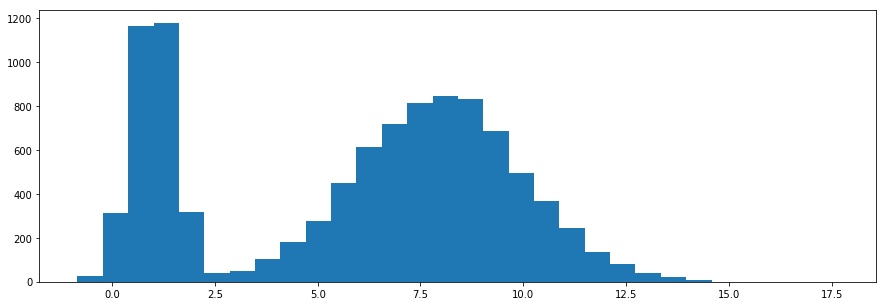

In [3]:
generative_model = model(
    locations=[1., 8.],
    scales=[.5, 2.],
    pmix=.3)

observations = sess.run(generative_model.sample(10000))
plt.figure(figsize=(15, 5))
plt.hist(observations, bins=30)
plt.show()

## Define a loss function
We define a loss function based on our generative model defined previously and our priors on the generative model
parameters

In [4]:
PRIOR_LOCATIONS = tf.constant([0., 0.])
PRIOR_SCALES = tf.constant([1., 1.])
PRIOR_PMIX = tf.constant(.5)

def log_probs(sample_locations, sample_scales, sample_pmix):
    rv_locations = tfd.Normal(loc=PRIOR_LOCATIONS, scale=PRIOR_SCALES)
    rv_scales = tfd.Exponential(rate=PRIOR_SCALES)
    rv_probs = tfd.Uniform(low=0., high=1.)
    rv_observations = model(sample_locations, sample_scales, sample_pmix)
    return (
        tf.reduce_sum(rv_locations.log_prob(sample_locations)) +
        tf.reduce_sum(rv_scales.log_prob(sample_scales)) +
        tf.reduce_sum(rv_probs.log_prob(sample_pmix)) + 
        tf.reduce_sum(rv_observations.log_prob(observations))
    )

## Sample posterior using MCMC
Now we use MCMC to sample the posterior.

In [5]:
NUM_BURNIN = 1000
NUM_SAMPLES = 1000


with tf.variable_scope(tf.get_variable_scope(), reuse=tf.AUTO_REUSE):
    step_size = tf.get_variable(
        name='step_size',
        initializer=tf.constant(0.5, dtype=tf.float32),
        trainable=False,
        use_resource=True
    )

kernel = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=log_probs,
    num_leapfrog_steps=2,
    step_size=step_size,
    step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(),
    state_gradients_are_stopped=True)

kernel = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=kernel,
    bijector=[tfb.Identity(), tfb.Exp(), tfb.Sigmoid()])

samples = tfp.mcmc.sample_chain(
    num_results=NUM_SAMPLES,
    num_burnin_steps=NUM_BURNIN,
    current_state=[PRIOR_LOCATIONS, PRIOR_SCALES, PRIOR_PMIX],
    kernel=kernel)

sess.run((
    tf.local_variables_initializer(),
    tf.global_variables_initializer()
))
[loc_samples, scale_samples, pmix_samples], kernel_results = sess.run(samples)

## Recover our mixture parameters
Using the sampled posterior distribution, we plot our inferred distribution and see that it fits our data well, learning our
original data generating parameters.

In [6]:
inferred_model = model(
    loc_samples.mean(axis=0), 
    scale_samples.mean(axis=0), 
    tf.to_float(pmix_samples.mean())
)

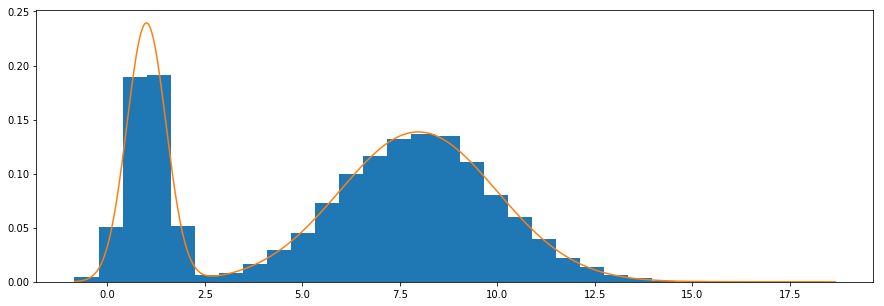

In [7]:
x = np.linspace(observations.min(), observations.max()+1, 1000)
plt.figure(figsize=(15, 5))
plt.hist(observations, bins=30, density=True)
plt.plot(x, sess.run(inferred_model.prob(x)))
plt.show()